# On the usefulness of variance reduced methods to optimize DL models

In [2]:
import os
import time
import datetime
from tqdm import tqdm_notebook

import numpy as np
import pandas
import matplotlib.pyplot as plt
from sklearn import metrics

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms, utils
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from keras.layers import Dense, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dropout, BatchNormalization
from keras.optimizers import SGD, Adam
from keras.datasets import cifar10
from keras.utils.np_utils import to_categorical
from keras.models import Model
from keras.models import Sequential
from keras.callbacks import EarlyStopping, Callback

Using TensorFlow backend.


In [3]:
!pip install svrg-optimizer-keras
from SVRGoptimizerKeras.optimizer import SVRG

In [4]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [5]:
def load_cifar_data():
    """Loads the CIFAR-10 dataset using Keras and preprocess for training."""
    # Download / Load the datasets
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    
    # Normalize the data
    y_train = to_categorical(y_train, 10)
    y_test  = to_categorical(y_test, 10)
    x_train = x_train.astype('float32') / 255
    x_test  = x_test.astype('float32') / 255
    
    # Label vector
    labels = [
        'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 
        'frog', 'horse', 'ship', 'truck'
    ]
    
    return x_train, y_train, x_test, y_test, labels

In [6]:
def show_first_n_images_in_categories(n, images, categories, labels, file_name=None):
    """Plots the first n images in each category from the image data."""
    f, axes = plt.subplots(n, 10, figsize=(11,8))
    
    for i in range(10):
        count = 0
        j = 0
        while count < n and j < 50000:
            if categories[j][i] == 1:
                axes[count,i].imshow(images[j,:,:,:])
                axes[count,i].axis('off')
                if count == 0:
                    axes[count,i].set_title(labels[i])
                count += 1
            j += 1

    if file_name:
        plt.savefig(file_name)
    else:
        plt.show()

In [7]:
def cnn_model(input_shape, num_classes, optimizer):
    """Compile CNN model for a given optimizer."""
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Conv2D(32,(3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
  
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
 
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [8]:
def train_model(model, x, y, batch_size=32, epochs=10, file_name=None, verbose=1, early_stopping=True, callbacks=[]):
    """
    Trains the model on the given data.
    """
    
    stop_early = EarlyStopping(monitor='val_acc', min_delta=0, patience=2, mode='auto')
    
    if early_stopping:
      callbacks = [stop_early] + callbacks
    
    ret = model.fit(x, y, batch_size=batch_size, epochs=epochs, validation_split=0.2, shuffle=True, 
                      callbacks=callbacks, verbose=verbose)

    if file_name:
        model.save(file_name)
    
    return ret

In [9]:
def eval_model(trained_model):
    """Plot learning curves for a given input model."""
    # Plot the evolution of (train/val) accuracy through epochs
    plt.plot(trained_model.history['acc'])
    plt.plot(trained_model.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
  

# Table of content

[1. A first look at the data set](#dataset)<br>

[2. Comparison of different optimizers](#comparisons)<br>


<a id='dataset'></a>
# 1 - A first look at the data set

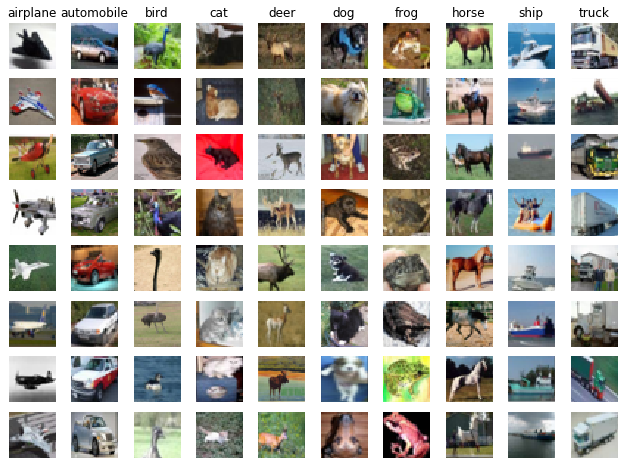

In [10]:
x_train, y_train, x_test, y_test, labels = load_cifar_data()
show_first_n_images_in_categories(8, x_train, y_train, labels, file_name=None)

#Reducing the size of the training set

#x_train = x_train[range(5000),:,:,:]
#y_train = y_train[range(5000)]

#x_test = x_train[range(500),:,:,:]
#y_test = y_train[range(500)]



<a id='comparisons'></a>

# 2 - CNN with different optimizers


## SGD

In [0]:
sgd = SGD(lr=0.1, decay=1.0e-6)
cnn_sgd = cnn_model(x_train.shape[1:], 10, optimizer=sgd)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 40000 samples, validate on 10000 samples
Epoch 1/10





40000/40000 [==============================] - 13s 323us/step - loss: 1.9206 - acc: 0.2989 - val_loss: 1.5301 - val_acc: 0.4519
Epoch 2/10
40000/40000 [==============================] - 8s 190us/step - loss: 1.3295 - acc: 0.5256 - val_loss: 1.1851 - val_acc: 0.5726
Epoch 3/10
40000/40000 [==============================] - 8s 195us/step - loss: 1.0738 - acc: 0.6199 - val_loss: 1.0493 - val_acc: 0.6362
Epoch 4/10
40000/40000 [==============================] - 8s 193us/step - loss: 0.8770 - acc: 0.6920 - val_loss: 0.9694 - val_acc: 0.6635
Epoch 5/10
40000/40000 [==============================] - 8s 190us/step - loss: 0.7096 - acc: 0.7496 - val_loss: 1.0080 - val_acc: 0.6644
Epoch 6/10
40000/40000 [==============================] - 8s 199us/step - loss: 0.5485 - acc: 0.8080 - val_loss: 1.0555 - val_acc: 0.6710
Epoch 7/10
40

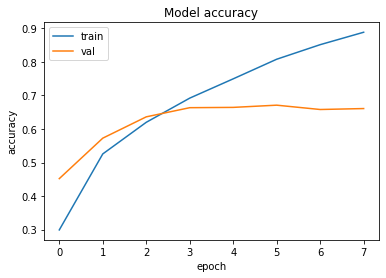

In [10]:
cnn_sgd_trained = train_model(cnn_sgd, x_train, y_train, batch_size=32)
eval_model(cnn_sgd_trained)

### Tuning parameters SGD

In [0]:
def tune_SGD(lr_space, decay_space):
  for decay in decay_space:
    print("decay =", decay)
    # Compute
    accuracies = []
    val_accuracies = []
    for lr in lr_space:
      print("lr =", lr)
      sgd = SGD(lr, decay=decay)
      cnn_sgd = cnn_model(x_train.shape[1:], 10, optimizer=sgd)
      cnn_sgd_trained = train_model(cnn_sgd, x_train, y_train, batch_size=32, epochs=5, verbose=0)
      accuracies.append(cnn_sgd_trained.history['acc'][-1])
      val_accuracies.append(cnn_sgd_trained.history['val_acc'][-1])
    
    # Display
    plt.xscale('log')
    plt.scatter(lr_space, accuracies)
    plt.scatter(lr_space, val_accuracies)
    plt.title('Final model accuracy for different learning rates. Decay '+ str(decay))
    plt.ylabel('Final accuracy')
    plt.xlabel('Learning rate')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

decay = 0.0001
lr = 1.0
lr = 0.5925530975545679
lr = 0.35111917342151316
lr = 0.2080567538217171
lr = 0.12328467394420663
lr = 0.07305271542664457
lr = 0.04328761281083059
lr = 0.02565020905680046
lr = 0.01519911082952934
lr = 0.009006280202112785
lr = 0.005336699231206312
lr = 0.003162277660168379


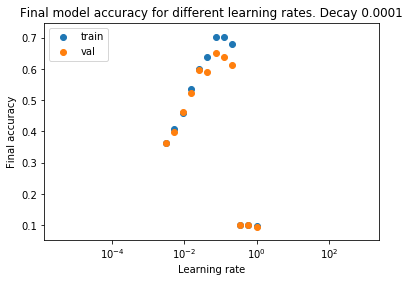

In [0]:
tune_SGD(1/np.power(10, np.linspace(0, 2.5, 12)), [1e-4])

## Adam

In [0]:
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
cnn_adam = cnn_model(x_train.shape[1:], 10, optimizer=adam)
cnn_adam_trained = train_model(cnn_adam, x_train, y_train, batch_size=32)

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 12s 288us/step - loss: 1.4251 - acc: 0.4804 - val_loss: 1.3014 - val_acc: 0.5627
Epoch 2/10
40000/40000 [==============================] - 11s 268us/step - loss: 0.9591 - acc: 0.6622 - val_loss: 0.8926 - val_acc: 0.6929
Epoch 3/10
40000/40000 [==============================] - 11s 263us/step - loss: 0.7428 - acc: 0.7390 - val_loss: 0.8121 - val_acc: 0.7188
Epoch 4/10
40000/40000 [==============================] - 11s 263us/step - loss: 0.5827 - acc: 0.7946 - val_loss: 0.8186 - val_acc: 0.7335
Epoch 5/10
40000/40000 [==============================] - 11s 269us/step - loss: 0.4470 - acc: 0.8445 - val_loss: 0.8206 - val_acc: 0.7348
Epoch 6/10
40000/40000 [==============================] - 11s 265us/step - loss: 0.3241 - acc: 0.8852 - val_loss: 0.8576 - val_acc: 0.7411
Epoch 7/10
40000/40000 [==============================] - 11s 263us/step - loss: 0.2259 - acc: 0.9208 - val_loss: 1.

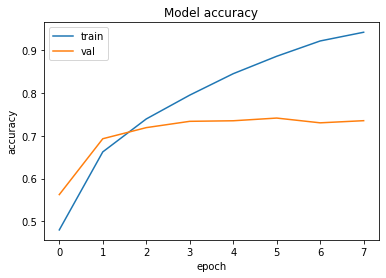

In [0]:
eval_model(cnn_adam_trained)

In [0]:
def tune_Adam(lr_space):
  # Compute
  accuracies = []
  val_accuracies = []
  for lr in lr_space:
    print("lr =", lr)
    adam = Adam(lr=lr, beta_1=0.9, beta_2=0.999, amsgrad=False)
    cnn_adam = cnn_model(x_train.shape[1:], 10, optimizer=adam)
    cnn_adam_trained = train_model(cnn_adam, x_train, y_train, batch_size=32, epochs=5, verbose=0)
    accuracies.append(cnn_adam_trained.history['acc'][-1])
    val_accuracies.append(cnn_adam_trained.history['val_acc'][-1])
  
  # Display
  plt.xscale('log')
  plt.scatter(lr_space, accuracies)
  plt.scatter(lr_space, val_accuracies)
  plt.title('Final model accuracy for different learning rates.')
  plt.ylabel('Final accuracy')
  plt.xlabel('Learning rate')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

lr = 0.01
lr = 0.006579332246575682
lr = 0.004328761281083057
lr = 0.002848035868435802
lr = 0.0018738174228603833
lr = 0.0012328467394420659
lr = 0.0008111308307896872
lr = 0.0005336699231206312
lr = 0.0003511191734215131
lr = 0.0002310129700083158
lr = 0.0001519911082952933
lr = 0.0001


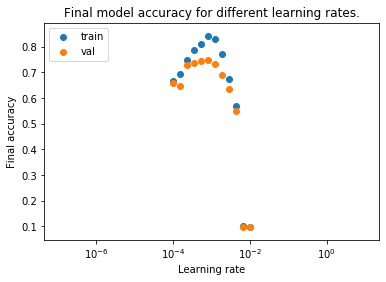

In [0]:
tune_Adam(1/np.power(10, np.linspace(2, 4, 12)))

In [0]:
def eval_models(trained_models, model_names):
    """Plot learning curves for a given input model."""
    # Plot the evolution of (train/val) accuracy through epochs
    for trained_model in trained_models:
      plt.plot(trained_model.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Validation accuracy')
    plt.xlabel('epoch')
    plt.legend(model_names, loc='upper left')
    plt.show()

In [0]:
sgd = SGD(lr=0.015, decay=1.0e-4)
cnn_sgd = cnn_model(x_train.shape[1:], 10, optimizer=sgd)
cnn_sgd_trained = train_model(cnn_sgd, x_train, y_train, batch_size=32, epochs=20, early_stopping=False)

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 12s 293us/step - loss: 1.9715 - acc: 0.2838 - val_loss: 1.6671 - val_acc: 0.4114
Epoch 2/20
40000/40000 [==============================] - 10s 242us/step - loss: 1.5316 - acc: 0.4506 - val_loss: 1.4446 - val_acc: 0.4885
Epoch 3/20
40000/40000 [==============================] - 10s 239us/step - loss: 1.3538 - acc: 0.5172 - val_loss: 1.3166 - val_acc: 0.5328
Epoch 4/20
40000/40000 [==============================] - 10s 243us/step - loss: 1.2369 - acc: 0.5605 - val_loss: 1.2560 - val_acc: 0.5489
Epoch 5/20
40000/40000 [==============================] - 10s 241us/step - loss: 1.1355 - acc: 0.6009 - val_loss: 1.1608 - val_acc: 0.5865
Epoch 6/20
40000/40000 [==============================] - 10s 240us/step - loss: 1.0494 - acc: 0.6303 - val_loss: 1.1406 - val_acc: 0.5970
Epoch 7/20
40000/40000 [==============================] - 10s 238us/step - loss: 0.9649 - acc: 0.6617 - val_loss: 1.

In [0]:
adam = Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, amsgrad=False)
cnn_adam = cnn_model(x_train.shape[1:], 10, optimizer=adam)
cnn_adam_trained = train_model(cnn_adam, x_train, y_train, batch_size=32, epochs=20, early_stopping=False)

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 14s 339us/step - loss: 1.4603 - acc: 0.4689 - val_loss: 1.1519 - val_acc: 0.5932
Epoch 2/20
40000/40000 [==============================] - 11s 282us/step - loss: 1.0331 - acc: 0.6329 - val_loss: 0.9368 - val_acc: 0.6713
Epoch 3/20
40000/40000 [==============================] - 11s 280us/step - loss: 0.8166 - acc: 0.7175 - val_loss: 0.8567 - val_acc: 0.7027
Epoch 4/20
40000/40000 [==============================] - 11s 280us/step - loss: 0.6517 - acc: 0.7734 - val_loss: 0.7805 - val_acc: 0.7339
Epoch 5/20
40000/40000 [==============================] - 11s 280us/step - loss: 0.5109 - acc: 0.8222 - val_loss: 0.8307 - val_acc: 0.7237
Epoch 6/20
40000/40000 [==============================] - 12s 290us/step - loss: 0.3664 - acc: 0.8730 - val_loss: 0.8498 - val_acc: 0.7413
Epoch 7/20
40000/40000 [==============================] - 11s 278us/step - loss: 0.2451 - acc: 0.9159 - val_loss: 0.

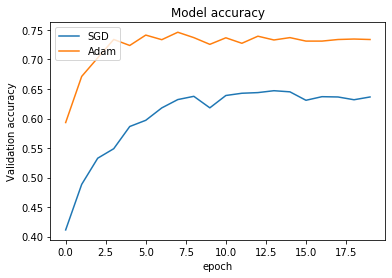

In [0]:
eval_models([cnn_sgd_trained, cnn_adam_trained], ['SGD', 'Adam'])

## Gradient Descent

In [0]:
# For GD, we need to subsample 50% of the dataset to avoid memory errors.
N_SUBSAMPLE = int(0.4 * x_train.shape[0])
ind_subsample = np.random.randint(0, x_train.shape[0], N_SUBSAMPLE)

x_train_sub = x_train[ind_subsample,:,:,:]
y_train_sub = y_train[ind_subsample]

In [0]:
def tune_GD(lr_space):
    val_accuracies = []
    for lr in lr_space:
        print("lr =", lr)
        sgd = SGD(lr)
        cnn_sgd = cnn_model(x_train_sub.shape[1:], 10, optimizer=sgd)
        cnn_gd_trained = train_model(cnn_sgd, x_train_sub, y_train_sub, batch_size=x_train_sub.shape[0], epochs=20, verbose=0)
        val_accuracies.append(cnn_gd_trained.history['val_acc'][-1])

    ind_max_val_acc = np.argmax(val_accuracies)
    best_lr = lr_space[ind_max_val_acc]
            
    return best_lr

In [12]:
best_lr_GD = tune_GD(100/np.power(10, range(8)))

lr = 100.0






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where








lr = 10.0
lr = 1.0
lr = 0.1
lr = 0.01
lr = 0.001
lr = 0.0001
lr = 1e-05


In [13]:
sgd = SGD(lr=best_lr_GD)
cnn_sgd = cnn_model(x_train_sub.shape[1:], 10, optimizer=sgd)
cnn_gd_trained = train_model(cnn_sgd, x_train_sub, y_train_sub, batch_size=x_train_sub.shape[0], epochs=100, verbose=1, early_stopping=False)

Train on 16000 samples, validate on 4000 samples
Epoch 1/100
16000/16000 [==============================] - 2s 115us/step - loss: 2.3062 - acc: 0.0822 - val_loss: 2.3016 - val_acc: 0.0988
Epoch 2/100
16000/16000 [==============================] - 1s 80us/step - loss: 2.3031 - acc: 0.0929 - val_loss: 2.2997 - val_acc: 0.1088
Epoch 3/100
16000/16000 [==============================] - 1s 80us/step - loss: 2.3009 - acc: 0.1034 - val_loss: 2.2980 - val_acc: 0.1157
Epoch 4/100
16000/16000 [==============================] - 1s 81us/step - loss: 2.2990 - acc: 0.1081 - val_loss: 2.2966 - val_acc: 0.1190
Epoch 5/100
16000/16000 [==============================] - 1s 80us/step - loss: 2.2974 - acc: 0.1114 - val_loss: 2.2952 - val_acc: 0.1240
Epoch 6/100
16000/16000 [==============================] - 1s 80us/step - loss: 2.2958 - acc: 0.1152 - val_loss: 2.2937 - val_acc: 0.1295
Epoch 7/100
16000/16000 [==============================] - 1s 80us/step - loss: 2.2942 - acc: 0.1218 - val_loss: 2.2923 - 

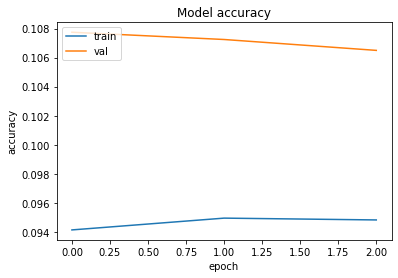

In [94]:
eval_model(cnn_gd_trained)

## SVRG

In [0]:
svrg = SVRG(lr=0.001)
cnn_svrg = cnn_model(x_train.shape[1:], 10, optimizer=svrg)
cnn_svrg_trained = train_model(cnn_svrg, x_train, y_train, batch_size=32)

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 13s 322us/step - loss: 2.2977 - acc: 0.1160 - val_loss: 2.2940 - val_acc: 0.1382
Epoch 2/10
40000/40000 [==============================] - 10s 257us/step - loss: 2.2897 - acc: 0.1345 - val_loss: 2.2849 - val_acc: 0.1354
Epoch 3/10
40000/40000 [==============================] - 10s 260us/step - loss: 2.2781 - acc: 0.1406 - val_loss: 2.2694 - val_acc: 0.1517
Epoch 4/10
40000/40000 [==============================] - 11s 264us/step - loss: 2.2541 - acc: 0.1812 - val_loss: 2.2331 - val_acc: 0.2172
Epoch 5/10
40000/40000 [==============================] - 10s 259us/step - loss: 2.2014 - acc: 0.2172 - val_loss: 2.1614 - val_acc: 0.2284
Epoch 6/10
40000/40000 [==============================] - 10s 255us/step - loss: 2.1509 - acc: 0.2261 - val_loss: 2.1359 - val_acc: 0.2056
Epoch 7/10
40000/40000 [==============================] - 10s 257us/step - loss: 2.1080 - acc: 0.2453 - val_loss: 2.

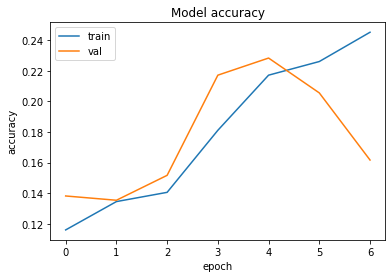

In [0]:
eval_model(cnn_svrg_trained)

In [0]:
def tune_SVRG(lr_space, decay_space):
  for decay in decay_space:
    print("decay =", decay)
    # Compute
    accuracies = []
    val_accuracies = []
    for lr in lr_space:
      print("lr =", lr)
      svrg = SVRG(lr, decay=decay)
      cnn_svrg = cnn_model(x_train.shape[1:], 10, optimizer=svrg)
      cnn_svrg_trained = train_model(cnn_svrg, x_train, y_train, batch_size=32, epochs=5, verbose=0)
      accuracies.append(cnn_svrg_trained.history['acc'][-1])
      val_accuracies.append(cnn_svrg_trained.history['val_acc'][-1])
    
    # Display
    plt.xscale('log')
    plt.scatter(lr_space, accuracies)
    plt.scatter(lr_space, val_accuracies)
    plt.title('Final model accuracy for different learning rates. Decay '+ str(decay))
    plt.ylabel('Final accuracy')
    plt.xlabel('Learning rate')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

decay = 0.0001
lr = 0.03162277660168379
lr = 0.01333521432163324
lr = 0.005623413251903491
lr = 0.002371373705661655
lr = 0.001


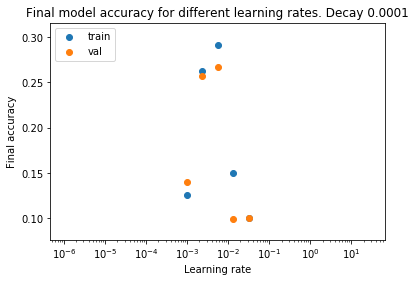

decay = 0.001
lr = 0.03162277660168379
lr = 0.01333521432163324
lr = 0.005623413251903491
lr = 0.002371373705661655
lr = 0.001


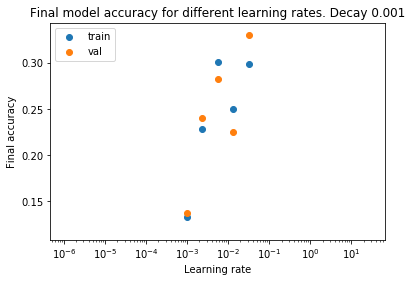

decay = 1e-05
lr = 0.03162277660168379
lr = 0.01333521432163324
lr = 0.005623413251903491
lr = 0.002371373705661655
lr = 0.001


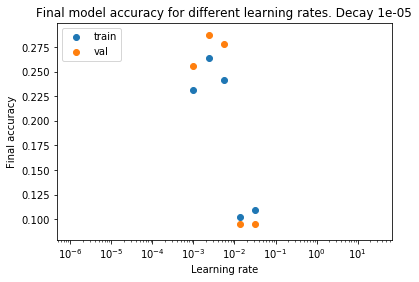

In [0]:
tune_SVRG(1/np.power(10, np.linspace(1.5, 3, 5)), [1e-4, 1e-3, 1e-5])

## Averaging

In [0]:
class Averaging(Callback):

    def __init__(self, share_avg):
        super(Averaging, self).__init__()
        self.share_avg = share_avg
        self.weights_to_avg = []

    def on_train_begin(self, logs={}):
        self.n_epochs = self.params['epochs']
        self.epoch_start_avg = int((1 - self.share_avg) * self.n_epochs)
        n_epochs_avg = self.n_epochs - self.epoch_start_avg
        print(f'Averaging SGD weights of last {n_epochs_avg} epochs.')
        print(self.epoch_start_avg)

    def on_epoch_end(self, epoch, logs={}):
        # Keep record of all weights after the iteration chosen to start avg
        if epoch > self.epoch_start_avg:
            wgt = np.array(self.model.get_weights())
            self.weights_to_avg.append(wgt)

    def on_train_end(self, logs={}):
        # Output average of stored weights
        averaged_weights = np.mean(self.weights_to_avg, axis=0)
        self.model.set_weights(averaged_weights)
        print('Final model parameters set to averaged weights.')

In [0]:
avg_callback = Averaging(share_avg=0.5)
sgd = SGD(lr=0.015, decay=1.0e-4)
cnn_sgd = cnn_model(x_train.shape[1:], 10, optimizer=sgd)
cnn_avg_trained = train_model(cnn_sgd, x_train, y_train, batch_size=32, epochs=20,
                              callbacks=[avg_callback], early_stopping=False)

Train on 40000 samples, validate on 10000 samples
Averaging SGD weights of last 10 epochs.
10
Epoch 1/20
40000/40000 [==============================] - 20s 488us/step - loss: 1.9447 - acc: 0.2963 - val_loss: 1.7014 - val_acc: 0.3998
Epoch 2/20
40000/40000 [==============================] - 11s 271us/step - loss: 1.5619 - acc: 0.4390 - val_loss: 1.4656 - val_acc: 0.4752
Epoch 3/20
40000/40000 [==============================] - 11s 271us/step - loss: 1.3782 - acc: 0.5085 - val_loss: 1.3384 - val_acc: 0.5201
Epoch 4/20
40000/40000 [==============================] - 11s 270us/step - loss: 1.2497 - acc: 0.5566 - val_loss: 1.2915 - val_acc: 0.5272
Epoch 5/20
40000/40000 [==============================] - 11s 267us/step - loss: 1.1392 - acc: 0.5967 - val_loss: 1.1817 - val_acc: 0.5878
Epoch 6/20
40000/40000 [==============================] - 11s 266us/step - loss: 1.0501 - acc: 0.6290 - val_loss: 1.2063 - val_acc: 0.5702
Epoch 7/20
40000/40000 [==============================] - 11s 266us/step

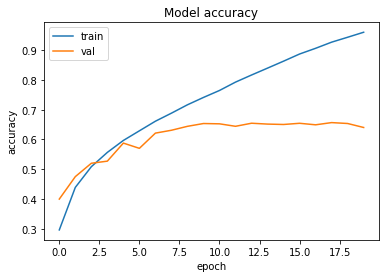

In [0]:
eval_model(cnn_avg_trained)

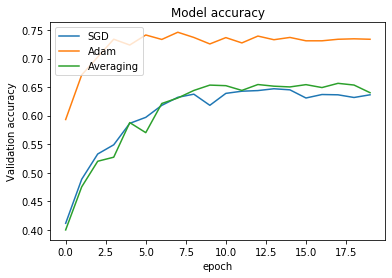

In [0]:
eval_models([cnn_sgd_trained, cnn_adam_trained, cnn_avg_trained], ['SGD', 'Adam', 'Averaging'])